In [1]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [201]:
class User:
    def __init__(self, user_id,importance_features, not_sincerity=False):
        self.user_id = user_id
        self.importance_features = importance_features
        self.survey = pd.DataFrame(columns=['no','temp','hum', 'lux', 'score'])
        self.not_sincerity = not_sincerity
        
    def save_survey(self, no,temp, hum, lux ,score):
        self.survey = self.survey.append({
            "no": no,
            "temp": temp,
            "hum": hum,
            "lux": lux,
            "score": score
        }, ignore_index=True)
    
    def score(self, temp, hum, lux):
        _score = np.array([0,0,0])
        
        if len(self.importance_features) == 0:
            if self.not_sincerity:
                for idx in range(0, len(_score)):
                    _score[idx] = 20
            else:
                one_line = ran.randrange(0, 2)
                if one_line == 0:
                    s = ran.randrange(5, 20, 5)
                    for idx in range(0, len(_score)):
                        _score[idx] = s
                else:
                    for idx in range(0, len(_score)):
                        _score[idx] = ran.randrange(5, 20)
        else:
            if 'temp' in self.importance_features:
                if (temp >= 18) & (temp <= 20):
                    _score[0] = 20
                else:
                    err = 0
                    if temp <= 18:
                        err = 18 - temp
                    else:
                        err = temp - 20
                    _score[0] = 20 - round(err / 2)
            else:
                _score[0] = ran.randrange(15, 20)
            
            if 'hum' in self.importance_features:
                if (hum >= 40) & (hum <= 60):
                    _score[1] = 20
                else:
                    err = 0
                    if hum <= 40:
                        err = 40 - hum
                    else:
                        err = hum - 60
                    _score[1] = 20 - round(err / 5)
            else:
                _score[1] = ran.randrange(15, 20)


            if 'lux' in self.importance_features:
                if (lux >= 700) & (lux <= 1500):
                    _score[2] = 20
                else:
                    err = 0
                    if lux < 700:
                        err = 700 - lux
                    else:
                        err = lux - 1500
                    _score[2] = 20 - round(err / 100)
            else:
                _score[2] = ran.randrange(15, 20)

        return _score.sum()
    
def generate_features():
    features = ['temp', 'hum', 'lux']
    imp_features = list()
    for f in features:
        is_in = ran.randrange(0,2)
        if is_in == 0:
            imp_features.append(f)
    
    if len(imp_features) == 0:
        is_in = ran.randrange(0, 3)
        imp_features.append(features[is_in])
        
    return imp_features            

In [222]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)
    
now = dt.datetime.now()

for days in range(0, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [223]:
max_temp = users[0].survey['temp'].max()
max_hum = users[0].survey['hum'].max()
max_lux = users[0].survey['lux'].max()

# 정규화
norm_no = users[0].survey['no'] / users[0].survey['no'].max()
norm_temp = users[0].survey['temp'] / max_temp
norm_hum = users[0].survey['hum'] / max_hum
norm_lux = users[0].survey['lux'] / max_lux

for idx in range(0, 100):
        users[idx].survey['no'] = norm_no
        users[idx].survey['temp'] = norm_temp
        users[idx].survey['hum'] = norm_hum
        users[idx].survey['lux'] = norm_lux

In [224]:
# features = np.array(['no', 'temp', 'hum', 'lux'])
features = np.array(['temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])
models = np.array([])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    RF_imp_features = None
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=100,
                                    max_features=3,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    models = np.append(models, RFModel)
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    if len(set(feature_importance)) == 1:
        RF_imp_features = []
    else:
        feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx][::-1]
    user_id = user.user_id
    user_imp_features = user.importance_features
    
    imp_length = len(user_imp_features)
    
    if RF_imp_features == None:
        if imp_length == 0:
            RF_imp_features = [_features[0]]
        else:
            RF_imp_features = _features[:imp_length]
        
    _imp_features = RF_imp_features
    imp_features = list()
    
    for _ in ['no', 'temp', 'hum', 'lux']:
        if _ in _imp_features:
            imp_features.append(_)

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(user_imp_features),
        "RF imp features": ",".join(imp_features)
    }, ignore_index=True)

In [225]:
part_user = _record[:50].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,3.38118


In [226]:
unpart_user = _record[50:].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(unpart_user)
compare_cnt = unpart_user[(unpart_user['imp features'] != "") & \
   (unpart_user['imp features'] == unpart_user['RF imp features'])].count()['imp features']
mean_mse = unpart_user[unpart_user['imp features'] == unpart_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,0,0.0


In [227]:
anal_user = part_user.copy()

anal_user['temp'] = part_user['imp features'].map(lambda x: "temp" in x)
anal_user['hum'] = part_user['imp features'].map(lambda x: "hum" in x)
anal_user['lux'] = part_user['imp features'].map(lambda x: "lux" in x)

apt_anal = pd.DataFrame()
apt_anal['온도'] = [anal_user[anal_user['temp'] == True].count().values[0]]
apt_anal['습도'] = [anal_user[anal_user['hum'] == True].count().values[0]]
apt_anal['조도'] = [anal_user[anal_user['lux'] == True].count().values[0]]

apt_anal

,온도,습도,조도
0,22,31,33


In [228]:
survey_mean = np.array([])
feature_tmp = np.array([])

for _ in users[0].survey.values:
    feature_tmp = np.append(feature_tmp,_[1:4])
feature_tmp = feature_tmp.reshape(-1, 3)

for survey_no in range(0,540):
    _tmp = np.array([])
    for user_no in range(0, 50):
        _tmp = np.append(_tmp, users[user_no].survey.loc[survey_no]['score'])
    survey_mean = np.append(survey_mean,_tmp.mean())

In [229]:
feature_tmp

array([[0.8125, 0.875, 0.7368421052631579],
       [0.59375, 0.4375, 0.10526315789473684],
       [0.78125, 0.4125, 0.3684210526315789],
       ...,
       [0.75, 0.575, 0.5263157894736842],
       [1.0, 0.3875, 0.47368421052631576],
       [0.3125, 0.65, 0.2631578947368421]], dtype=object)

In [230]:
survey_mean

array([53.8 , 52.08, 54.72, 51.36, 50.76, 53.14, 53.18, 51.84, 53.14,
       54.66, 56.32, 53.4 , 52.78, 49.54, 52.04, 55.  , 54.2 , 54.48,
       53.3 , 51.94, 53.34, 52.46, 55.4 , 52.86, 53.22, 50.58, 53.78,
       54.04, 54.74, 53.94, 55.82, 50.42, 53.26, 52.76, 53.78, 54.7 ,
       55.54, 52.58, 53.76, 54.36, 53.54, 52.16, 52.56, 50.78, 51.74,
       51.84, 51.54, 49.38, 51.88, 51.46, 53.74, 53.74, 55.7 , 51.32,
       55.7 , 53.28, 55.48, 49.72, 53.48, 56.28, 51.82, 55.42, 54.46,
       55.5 , 51.5 , 55.38, 53.76, 53.38, 55.32, 53.5 , 54.8 , 54.86,
       53.16, 53.88, 55.34, 50.54, 53.16, 52.88, 56.08, 52.  , 54.54,
       55.58, 54.96, 53.68, 51.28, 53.1 , 52.66, 53.98, 54.06, 53.5 ,
       52.54, 52.8 , 55.9 , 52.52, 55.8 , 54.46, 54.12, 55.14, 52.66,
       55.1 , 50.7 , 56.16, 52.48, 54.64, 55.6 , 52.1 , 55.38, 53.32,
       51.88, 50.24, 55.6 , 51.12, 51.12, 53.18, 51.02, 50.94, 52.64,
       53.38, 55.76, 52.5 , 52.98, 55.06, 53.68, 55.12, 54.98, 53.2 ,
       54.96, 53.44,

In [231]:
anal_mean = pd.DataFrame(columns=["실제 설문점수", "예측 설문점수"])
anal_np = np.array([])

for user_idx in range(0,50):
    anal_np = np.append(anal_np,
        models[user_idx].predict(feature_tmp))
    
for idx,pre in enumerate(anal_np.reshape(-1, 540).mean(axis=0)):
    anal_mean.loc[idx] = [
        survey_mean[idx],
        pre
    ]

In [232]:
anal_mean

,실제 설문점수,예측 설문점수
0,53.80,51.802667
1,52.08,55.240000
2,54.72,52.680000
3,51.36,49.860000
4,50.76,53.400000
...,...,...
535,53.78,54.120000
536,53.78,51.460000
537,55.46,52.200000
538,52.34,48.700000


In [233]:
(anal_mean['실제 설문점수'] - anal_mean['예측 설문점수']).abs().mean()

2.390899735449734

[0.21389421 0.27549858 0.51060721]
[0.41890165 0.5395509  1.        ]
[2 1 0]
['temp' 'hum' 'lux']
0.1845568074897109


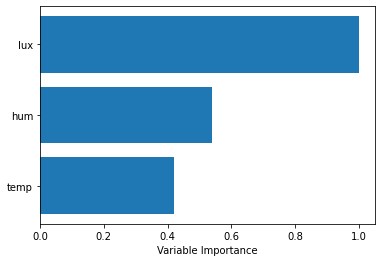

In [234]:
features = np.array(['temp', 'hum', 'lux'])

X_train, X_test, y_train, y_test = train_test_split(feature_tmp,survey_mean,test_size=0.2)

RFModel = RandomForestRegressor(n_estimators=100,
                                max_features=3,
                            oob_score=False,random_state=531)
RFModel.fit(X_train, y_train.ravel())
prediction = RFModel.predict(X_test)

mse = mean_squared_error(y_test,prediction)

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

print(RFModel.feature_importances_)
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
print(sorted_idx[::-1])
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx]

print(_features)
print(mse)
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()

In [235]:
X_train

array([[0.40625, 0.95, 0.7894736842105263],
       [0.625, 0.875, 1.0],
       [1.0, 0.95, 0.2631578947368421],
       ...,
       [0.78125, 0.7125, 0.8421052631578947],
       [0.4375, 0.9, 0.2631578947368421],
       [0.84375, 0.5375, 0.21052631578947367]], dtype=object)

In [243]:
new_survey = pd.DataFrame(columns=['실제 설문 점수 (평균)', '예측 설문 점수', '오차'])

for days in range(0, 500):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    
    np_features = np.array([[ran_temp / max_temp,
                             ran_hum / max_hum, 
                             ran_lux / max_lux]])
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    new_survey.loc[days] = [
        user_scores.mean(),
        RFModel.predict(np_features)[0],
        abs(user_scores.mean() - RFModel.predict(np_features)[0])
    ]

In [251]:
print("해당 모델의 오차 평균은 {}점 입니다.".format(round(new_survey['오차'].mean() * 1000) / 1000))

해당 모델의 오차 평균은 0.318점 입니다.


<AxesSubplot:>

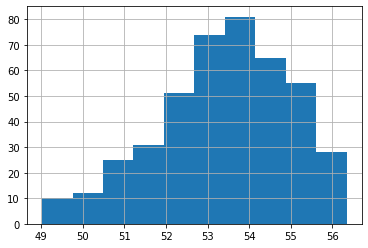

In [260]:
pd.Series(y_train).hist(bin=)

In [266]:
max_score = y_train[y_train.argmax()]
min_score = y_train[y_train.argmin()]

print("설문점수 중 가장 높은 점수는 {}점 이었으며,\n".format(max_score) \
     + "가장 낮은 점수는 {}점 이었습니다.".format(min_score))

설문점수 중 가장 높은 점수는 56.34점 이었으며,
가장 낮은 점수는 49.02점 이었습니다.


In [269]:
X_train[y_train.argmax()] * [max_temp, max_hum, max_lux]

array([20.0, 58.0, 1100.0], dtype=object)

In [ ]:
X_train[y_train.argmax()] * [max_temp, max_hum, max_lux]